In [ ]:
import zipfile

path_to_zip_file = '/content/datadenekSON.zip'

directory_to_extract_to = '/content'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

51877672/51877672 [==============================] - 1s 0us/step
Epoch 1/50
65/64 [==============================] - ETA: 0s - loss: 7.5927 - accuracy: 0.8482
Epoch 1: val_accuracy improved from -inf to 0.94218, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 52s 435ms/step - loss: 7.5927 - accuracy: 0.8482 - val_loss: 6.3912 - val_accuracy: 0.9422 - lr: 1.0000e-04
Epoch 2/50
65/64 [==============================] - ETA: 0s - loss: 5.6249 - accuracy: 0.9319
Epoch 2: val_accuracy improved from 0.94218 to 0.96712, saving model to best_model.h5
64/64 [==============================] - 16s 249ms/step - loss: 5.6249 - accuracy: 0.9319 - val_loss: 4.8031 - val_accuracy: 0.9671 - lr: 1.0000e-04
Epoch 3/50
65/64 [==============================] - ETA: 0s - loss: 4.2565 - accuracy: 0.9635
Epoch 3: val_accuracy did not improve from 0.96712
64/64 [==============================] - 15s 227ms/step - loss: 4.2565 - accuracy: 0.9635 - val_loss: 3.6990 - val_accuracy: 0.9615 - lr: 1.0000e-04
Epoch 4/50
65/64 [==============================] - ETA: 0s - loss: 3.2797 - accuracy: 0.9664
Epoch 4: val_accuracy improved from 0.96712 to 0.98753, saving model to best_model.h5
64/64 [==============================] - 16s 245

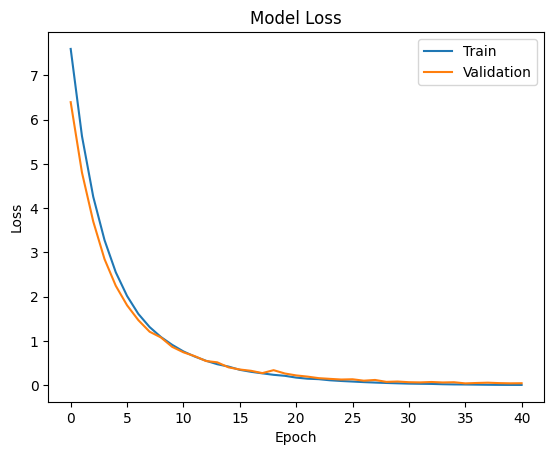

28/28 [==============================] - 5s 92ms/step
Precision: 0.99
Recall: 1.00
F1 Score: 0.99


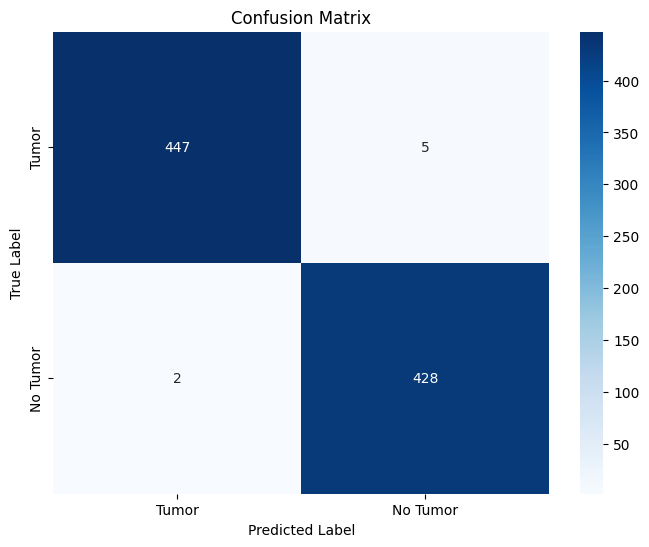

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, DenseNet169
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

unfreeze_layers_vgg = 5
unfreeze_layers_densenet = 20

train_yes_path = '/content/datadenek2/beyin/veri/yes1'
train_no_path = '/content/datadenek2/beyin/veri/no1'

data = []
labels = []

for r, d, f in os.walk(train_yes_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(0)

for r, d, f in os.walk(train_no_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(1)

if len(data) == 0 or len(labels) == 0:
    raise ValueError("Data or labels are empty. Please check the data loading process.")

data = np.array(data)
labels = np.array(labels)

encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=0)

x_train = x_train / 255.0
x_test = x_test / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
)

train_datagen.fit(x_train)

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg19.layers:
    layer.trainable = False

for layer in vgg19.layers[-unfreeze_layers_vgg:]:
    layer.trainable = True

densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in densenet169.layers:
    layer.trainable = False

for layer in densenet169.layers[-unfreeze_layers_densenet:]:
    layer.trainable = True

vgg19_output = vgg19.output
densenet169_output = densenet169.output

vgg19_output = layers.GlobalAveragePooling2D()(vgg19_output)
densenet169_output = layers.GlobalAveragePooling2D()(densenet169_output)

merged = layers.concatenate([vgg19_output, densenet169_output])

x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='sigmoid')(x)

model = Model(inputs=[vgg19.input, densenet169.input], outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_datagen.flow([x_train, x_train], y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    validation_data=([x_test, x_test], y_test),
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

evaluation_results = model.evaluate([x_test, x_test], y_test)
accuracy = evaluation_results[1]
print("Model Accuracy on Test Set: {:.2f}%".format(accuracy * 100))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

y_pred = model.predict([x_test, x_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Tumor', 'No Tumor'], yticklabels=['Tumor', 'No Tumor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()